In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [50]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [51]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [52]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [53]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [55]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [56]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for col in measurement_columns:
    print(col["name"], col["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [57]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns("station")
for col in measurement_columns:
    print(col["name"], col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [58]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(recent_date)

('2017-08-23',)


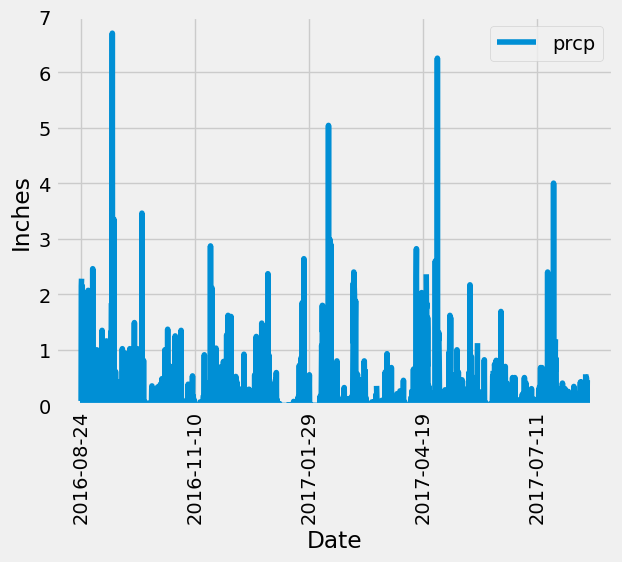

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

previous = dt.date(2017,8,23)- dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > previous).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df_precip = pd.DataFrame(precip_data)
df2_precip = df_precip.set_index("date")
df2_precip

# Sort the dataframe by date
    # sorted dataframe by using order_by in previous cell 

# Use Pandas Plotting with Matplotlib to plot the data
df2_precip.plot()
plt.ylim(0,7)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [60]:
# Use Pandas to calculate the summary statistics for the precipitation data
df2_precip.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [61]:
# Design a query to calculate the total number of stations in the dataset
total_stations= session.query(Station.station).count()
total_stations

9

In [62]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sta = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sta).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sta = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station = session.query(*sta).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_active_station

(54.0, 85.0, 71.66378066378067)

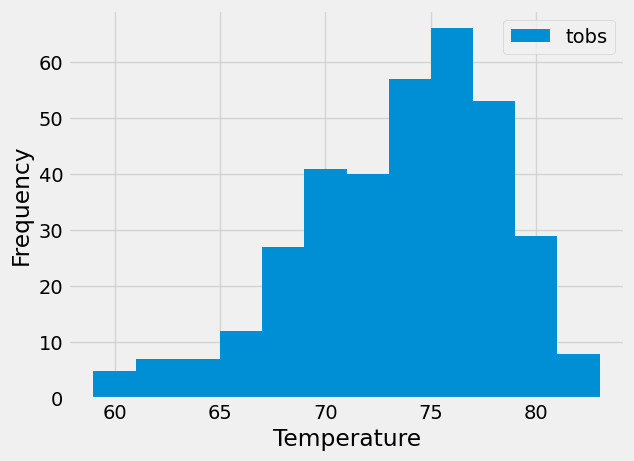

In [64]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_twelve = session.query(Measurement.tobs).\
    filter(Measurement.station == active_stations[0][0]).\
    filter(Measurement.date >= previous).all()
temperature = list(np.ravel(last_twelve))

sta = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
precip_data = session.query(*sta).all()
stations_desc = pd.DataFrame(precip_data, columns=['Station','Name','Latitude','Longitude','Elevation'])

station_name = stations_desc.loc[stations_desc["Station"] == active_stations[0][0],"Name"].tolist()[0]

plt.hist(temperature, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel ('Temperature')
plt.legend()


# Close Session

In [65]:
# Close Session
session.close()